Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


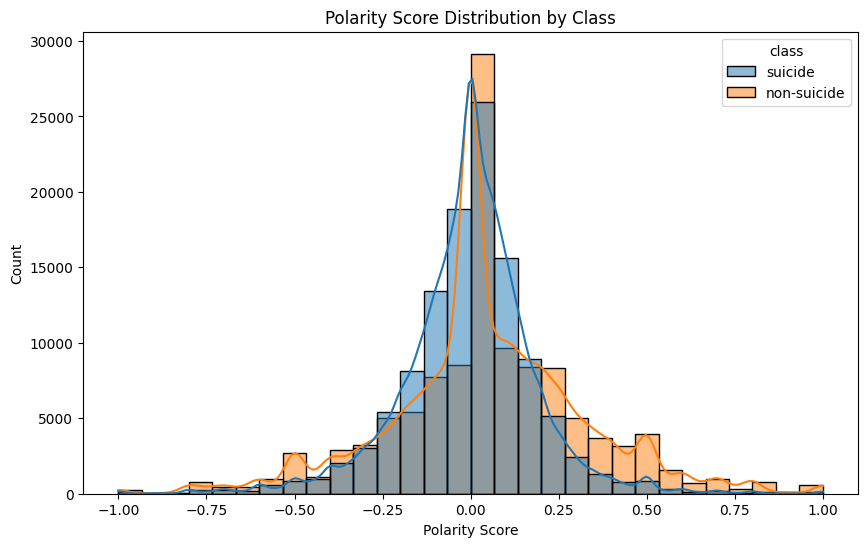

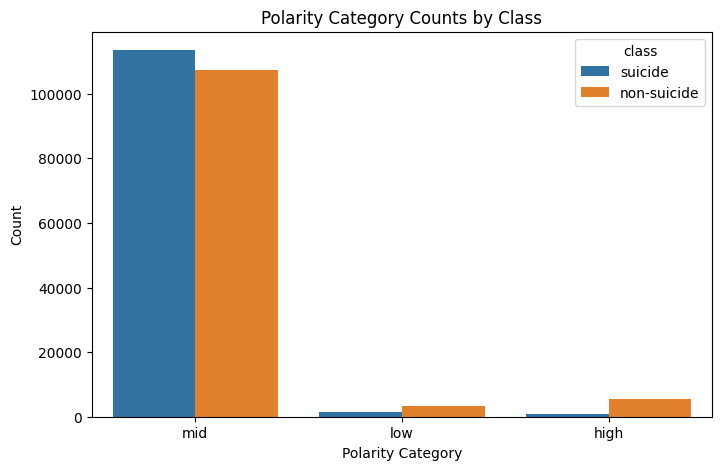

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset.csv', encoding="ISO-8859-1")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

def categorize_polarity(score):
    if score < -0.5:
        return 'low'
    elif -0.5 <= score <= 0.5:
        return 'mid'
    else:
        return 'high'

df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='polarity_score', hue='class', kde=True, bins=30)
plt.title('Polarity Score Distribution by Class')
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='polarity_category', hue='class')
plt.title('Polarity Category Counts by Class')
plt.xlabel('Polarity Category')
plt.ylabel('Count')
plt.show()





In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,text,class,polarity_score,polarity_category
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,0.071429,mid
1,Am I weird I don't get affected by compliments...,non-suicide,0.100000,mid
2,Finally 2020 is almost over... So I can never ...,non-suicide,-0.525000,low
3,i need helpjust help me im crying so hard,suicide,-0.245833,mid
4,"IÃ¢ÂÂm so lostHello, my name is Adam (16) an...",suicide,-0.128410,mid


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

# Load the saved GRU model
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

# Load the saved tokenizer
with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

def categorize_polarity(score):
    if score < -0.5:
        return 'low'
    elif -0.5 <= score <= 0.5:
        return 'mid'
    else:
        return 'high'

df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)

df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

X_text = df['text']  # Text feature
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values
y = pd.get_dummies(df['class']).values

from sklearn.model_selection import train_test_split
X_train_text, X_test_text, X_train_polarity, X_test_polarity, y_train, y_test = train_test_split(
    X_text, X_polarity, y, test_size=0.3, random_state=42
)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_text_seq = pad_sequences(X_train_text_seq, maxlen=200, padding='post')
X_test_text_seq = pad_sequences(X_test_text_seq, maxlen=200, padding='post')

# Evaluate the pre-trained model
print("Evaluating the pre-trained GRU model...")
y_pred = model.predict(X_test_text_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy (Pre-Trained Model): {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print("Classification Report (Pre-Trained Model):")
print(classification_report(y_test_classes, y_pred_classes))


Evaluating the pre-trained GRU model...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 239s 110ms/step
Accuracy (Pre-Trained Model): 0.66
Classification Report (Pre-Trained Model):
              precision    recall  f1-score   support

           0       0.73      0.50      0.59     34824
           1       0.62      0.82      0.70     34799

    accuracy                           0.66     69623
   macro avg       0.67      0.66      0.65     69623
weighted avg       0.67      0.66      0.65     69623



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

# Load the saved GRU model
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

# Load the saved tokenizer
with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

X_text = df['text']  # Text feature
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values
y = pd.get_dummies(df['class']).values

from sklearn.model_selection import train_test_split
X_train_text, X_test_text, X_train_polarity, X_test_polarity, y_train, y_test = train_test_split(
    X_text, X_polarity, y, test_size=0.3, random_state=42
)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_text_seq = pad_sequences(X_train_text_seq, maxlen=200, padding='post')
X_test_text_seq = pad_sequences(X_test_text_seq, maxlen=200, padding='post')

# Evaluate the pre-trained model
print("Evaluating the pre-trained GRU model...")
y_pred = model.predict(X_test_text_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy (Pre-Trained Model): {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print("Classification Report (Pre-Trained Model):")
print(classification_report(y_test_classes, y_pred_classes))


X_train_combined = np.hstack([X_train_text_seq, X_train_polarity])
X_test_combined = np.hstack([X_test_text_seq, X_test_polarity])

# Fine-tune the loaded model
print("Fine-tuning the GRU model with sentiment analysis features...")
history = model.fit(
    X_train_combined, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_combined, y_test)
)

# Evaluate the fine-tuned model
print("Evaluating the fine-tuned GRU model...")
y_pred_fine_tuned = model.predict(X_test_combined)
y_pred_classes_fine_tuned = np.argmax(y_pred_fine_tuned, axis=1)

print(f"Accuracy (Fine-Tuned Model): {accuracy_score(y_test_classes, y_pred_classes_fine_tuned):.2f}")
print("Classification Report (Fine-Tuned Model):")
print(classification_report(y_test_classes, y_pred_classes_fine_tuned))

Evaluating the pre-trained GRU model...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 182s 83ms/step
Accuracy (Pre-Trained Model): 0.66
Classification Report (Pre-Trained Model):
              precision    recall  f1-score   support

           0       0.73      0.50      0.59     34824
           1       0.62      0.82      0.70     34799

    accuracy                           0.66     69623
   macro avg       0.67      0.66      0.65     69623
weighted avg       0.67      0.66      0.65     69623

Fine-tuning the GRU model with sentiment analysis features...
Epoch 1/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1576s 1s/step - accuracy: 0.8152 - loss: 0.4157 - val_accuracy: 0.8956 - val_loss: 0.2643
Epoch 2/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1568s 1s/step - accuracy: 0.8928 - loss: 0.2688 - val_accuracy: 0.9037 - val_loss: 0.2448
Epoch 3/15
 185/1270 ━━━━━━━━━━━━━━━━━━━━ 20:22 1s/step - accuracy: 0.9027 - loss: 0.2514

In [ ]:
fine_tuned_model_path = '/content/drive/My Drive/suicide_detection_GRU_fine_tuned.keras'
model.save(fine_tuned_model_path)
print(f"Fine-tuned model saved at: {fine_tuned_model_path}")


In [ ]:
# Apply the categorization
df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)

# Add one-hot encoded polarity categories
df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

# Remove duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Check available columns
print(df.columns)

# Split dataset
X_text = df['text']  # Text feature
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values  # Polarity features
y = pd.get_dummies(df['class']).values  # One-hot encode class labels

# Train-test split
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, X_train_polarity, X_test_polarity, y_train, y_test = train_test_split(
    X_text, X_polarity, y, test_size=0.3, random_state=42
)

# Tokenize text features
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, lower=True)
tokenizer.fit_on_texts(X_train_text)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_text_seq = pad_sequences(X_train_text_seq, maxlen=200, padding='post')
X_test_text_seq = pad_sequences(X_test_text_seq, maxlen=200, padding='post')

# Combine tokenized text with polarity features
X_train_combined = np.hstack([X_train_text_seq, X_train_polarity])
X_test_combined = np.hstack([X_test_text_seq, X_test_polarity])

# Define input dimension
vocab_size = 10000  # Vocabulary size for embedding layer
input_length = X_train_text_seq.shape[1]  # Input length for text sequences

# Define the GRU model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=X_train_combined.shape[1]))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_combined, y_train,
    epochs=10, batch_size=128,
    validation_data=(X_test_combined, y_test)
)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy: {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print(classification_report(y_test_classes, y_pred_classes))


Index(['Unnamed: 0', 'text', 'class', 'polarity_score', 'polarity_high',
       'polarity_low', 'polarity_mid'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1966s 2s/step - accuracy: 0.7753 - loss: 0.4210 - val_accuracy: 0.9367 - val_loss: 0.1716
Epoch 2/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 2019s 2s/step - accuracy: 0.9455 - loss: 0.1500 - val_accuracy: 0.9399 - val_loss: 0.1634
Epoch 3/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1962s 2s/step - accuracy: 0.9524 - loss: 0.1327 - val_accuracy: 0.9408 - val_loss: 0.1635
Epoch 4/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1937s 2s/step - accuracy: 0.9599 - loss: 0.1133 - val_accuracy: 0.9390 - val_loss: 0.1743
Epoch 5/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1943s 2s/step - accuracy: 0.9651 - loss: 0.1006 - val_accuracy: 0.9386 - val_loss: 0.1743
Epoch 6/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1976s 2s/step - accuracy: 0.9710 - loss: 0.0844 - val_accuracy: 0.9336 - val_loss: 0.1912
Epoch 7/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 1959s 2s/step - accuracy: 0.9756 - loss: 0.0717 - val_accuracy: 0.9341 - val_loss: 0.2345
Epoch 8/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 2001s 2s/step - accuracy: 0.9792 -

In [ ]:
from textblob import TextBlob

def calculate_polarity_category(polarity_score):
    """
    Determines the polarity category based on the calculated polarity score.
    """
    if polarity_score < -0.5:
        return [1, 0, 0]  # low polarity
    elif -0.5 <= polarity_score <= 0.5:
        return [0, 1, 0]  # mid polarity
    else:
        return [0, 0, 1]  # high polarity

def user_input_testing_gru_with_benchmark():
    print("Enter text to classify (type 'exit' to quit):")
    while True:
        # Take user input
        user_text = input("Your text: ")
        if user_text.lower() == 'exit':
            print("Exiting. Goodbye!")
            break

        # Preprocess text
        processed_text = user_text.lower()  # Convert to lowercase
        sequence = tokenizer.texts_to_sequences([processed_text])  # Tokenize
        padded_sequence = pad_sequences(sequence, maxlen=200, padding='post')  # Pad sequence

        # Calculate polarity score and category
        polarity_score = TextBlob(user_text).sentiment.polarity
        polarity_category = calculate_polarity_category(polarity_score)  # [low, mid, high]

        # Combine text and polarity features
        polarity_features = np.array([polarity_category])
        input_combined = np.hstack([padded_sequence, polarity_features])

        # Make prediction
        prediction = model.predict(input_combined)
        suicide_prob = prediction[0][1] * 100  # Probability for suicide
        non_suicide_prob = prediction[0][0] * 100  # Probability for non-suicide

        # Output result with exact benchmark
        if suicide_prob >= 50:
            print(f"Prediction: Suicide Ideation ({suicide_prob:.2f}%)\n")
        else:
            print(f"Prediction: Non-Suicide Ideation ({non_suicide_prob:.2f}%)\n")


# Run the testing function
user_input_testing_gru_with_benchmark()



Enter text to classify (type 'exit' to quit):


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Generate predictions for the test dataset
y_pred = model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy and generate the classification report
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Suicide', 'Suicide'])

# Output the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


### **GRU_LR_Sentiment**

In [ ]:
from google.colab import drive
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from textblob import TextBlob
import re

# Mount Google Drive
drive.mount('/content/drive')

# Load models and other resources
gru_model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
gru_model = load_model(gru_model_path)

with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

lr_model_path = '/content/drive/MyDrive/logistic_regression_model.pkl'
with open(lr_model_path, 'rb') as f:
    lr_model = pickle.load(f)

tfidf_path = '/content/drive/MyDrive/tfidf_vectorizer.pkl'
with open(tfidf_path, 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Load dataset for label encoding
df = pd.read_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset.csv', encoding="ISO-8859-1")
df['class'] = df['class'].apply(lambda x: 1 if x == 'suicide' else 0)
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])

# Preprocess text
def preprocess_input(text):
    return text.lower()

# Sentiment Analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity  # Range: -1 (negative) to 1 (positive)
    if polarity > 0.5:
        sentiment = "positive"
    elif polarity < -0.5:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return polarity, sentiment

# GRU Prediction
def predict_with_gru(text):
    processed_text = preprocess_input(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=200, padding='post')
    prediction = gru_model.predict(padded_sequence)
    suicide_prob = prediction[0][1]

    if suicide_prob >= 0.5:
        return f"Suicide Ideation ({suicide_prob * 100:.2f}%)"
    else:
        return f"Non-Suicide Ideation ({(1 - suicide_prob) * 100:.2f}%)"

# Logistic Regression Prediction
def predict_with_lr(text):
    processed_text = preprocess_input(text)
    processed_tfidf = tfidf_vectorizer.transform([processed_text])
    prediction_probs = lr_model.predict_proba(processed_tfidf)[0]
    suicide_prob = prediction_probs[1]

    if suicide_prob >= 0.5:
        return f"Suicide Ideation ({suicide_prob * 100:.2f}%)"
    else:
        return f"Non-Suicide Ideation ({suicide_prob * 100:.2f}%)"

# Unified Testing with Sentiment Analysis
def unified_testing_with_sentiment():
    print("Enter text to classify or type 'exit' to quit.")
    while True:
        user_input = input("\nYour text: ").strip()
        if not user_input:
            print("Input cannot be empty. Please enter valid text.")
            continue
        if user_input.lower() == 'exit':
            print("Exiting. Goodbye!")
            break

        # Analyze sentiment
        polarity, sentiment = analyze_sentiment(user_input)
        print(f"\nSentiment Analysis: {sentiment} (Polarity Score: {polarity:.2f})")

        print("\nPredictions:")
        print("---------------------")
        try:
            gru_result = predict_with_gru(user_input)
            print(f"GRU Model: {gru_result}")
        except Exception as e:
            print(f"GRU Model Error: {str(e)}")

        try:
            lr_result = predict_with_lr(user_input)
            print(f"Logistic Regression Model: {lr_result}")
        except Exception as e:
            print(f"Logistic Regression Model Error: {str(e)}")
        print("---------------------\n")

def preprocess_text(text):
    """Preprocess the text for the dataset."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

df['preprocessed_text'] = df['text'].apply(preprocess_text)
# Example: Adding Personality-Like Features (Proxies)
def add_personality_features(df):
    # Feature: Text Length
    df['text_length'] = df['preprocessed_text'].apply(len)

    # Feature: Number of Words
    df['num_words'] = df['preprocessed_text'].apply(lambda x: len(x.split()))

    # Feature: Sentiment Polarity
    df['polarity_score'] = df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Feature: Subjectivity
    df['subjectivity_score'] = df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Feature: Average Word Length
    df['avg_word_length'] = df['preprocessed_text'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )

    return df

# Apply Personality-Like Feature Extraction
df = add_personality_features(df)

# Save the Updated Dataset
df.to_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset_With_Features.csv', index=False)
print("Dataset updated with personality-like features.")

# Run Unified Testing
unified_testing_with_sentiment()


Mounted at /content/drive
Dataset updated with personality-like features.
Enter text to classify or type 'exit' to quit.

Your text: exit
Exiting. Goodbye!


# **Adding Personality**

# LR_Personality

In [ ]:
# Import necessary libraries
import pandas as pd
from google.colab import drive
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Mount Google Drive
drive.mount('/content/drive')

# Step 1: Load the Saved Dataset
dataset_path = '/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset_With_Features.csv'
df = pd.read_csv(dataset_path)
print(f"Dataset loaded successfully from: {dataset_path}")

# Handle NaN values in the `preprocessed_text` column
if df['preprocessed_text'].isnull().sum() > 0:
    print(f"Found {df['preprocessed_text'].isnull().sum()} NaN values in 'preprocessed_text'. Replacing with empty strings.")
    df['preprocessed_text'] = df['preprocessed_text'].fillna("")

# Handle NaN values in personality-like features
personality_features = ['text_length', 'num_words', 'polarity_score', 'subjectivity_score', 'avg_word_length']
for feature in personality_features:
    if df[feature].isnull().sum() > 0:
        print(f"Found {df[feature].isnull().sum()} NaN values in '{feature}'. Replacing with zeros.")
        df[feature] = df[feature].fillna(0)

# Step 2: Prepare Features and Labels
X_text = df['preprocessed_text']  # Preprocessed text
X_polarity = df[personality_features].values  # Personality-like features
y = df['class'].apply(lambda x: 1 if x == 'suicide' else 0)  # Binary labels

# TF-IDF Vectorization
tfidf_path = '/content/drive/MyDrive/tfidf_vectorizer_sentiment.pkl'
with open(tfidf_path, 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
print(f"TF-IDF Vectorizer loaded successfully from: {tfidf_path}")

# Transform text using TF-IDF
X_text_tfidf = tfidf_vectorizer.transform(X_text)

# Combine TF-IDF features with personality-like features
X_combined = np.hstack([X_text_tfidf.toarray(), X_polarity])

# Ensure there are no NaN values in the combined features
if np.isnan(X_combined).sum() > 0:
    print(f"Found {np.isnan(X_combined).sum()} NaN values in combined features. Replacing with zeros.")
    X_combined = np.nan_to_num(X_combined)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)
print("Train-test split completed.")

# Step 4: Load the Logistic Regression Model
lr_model_path = '/content/drive/MyDrive/logistic_regression_sentiment_fine_tuned.pkl'
with open(lr_model_path, 'rb') as f:
    lr_model = pickle.load(f)
print(f"Logistic Regression model loaded successfully from: {lr_model_path}")

# Ensure feature size matches model expectations
expected_feature_size = lr_model.coef_.shape[1]
if X_test.shape[1] != expected_feature_size:
    print(f"Adjusting feature size to match model's expectations. Expected: {expected_feature_size}, Found: {X_test.shape[1]}")
    if X_test.shape[1] < expected_feature_size:
        # Pad with zeros if the feature size is smaller
        padding = np.zeros((X_test.shape[0], expected_feature_size - X_test.shape[1]))
        X_test = np.hstack([X_test, padding])
    else:
        # Truncate features if the feature size is larger
        X_test = X_test[:, :expected_feature_size]

# Step 5: Evaluate Logistic Regression Model
y_pred_lr = lr_model.predict(X_test)
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


# GRU_Personality

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset.csv', encoding="ISO-8859-1")

Mounted at /content/drive


In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,text,class,polarity_score
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,0.071429
1,Am I weird I don't get affected by compliments...,non-suicide,0.100000
2,Finally 2020 is almost over... So I can never ...,non-suicide,-0.525000
3,i need helpjust help me im crying so hard,suicide,-0.245833
4,"IÃ¢ÂÂm so lostHello, my name is Adam (16) an...",suicide,-0.128410


In [ ]:
def categorize_polarity(score):
    if score < -0.5:
        return 'low'
    elif -0.5 <= score <= 0.5:
        return 'mid'
    else:
        return 'high'

df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)

# plt.figure(figsize=(10, 6))
# sns.histplot(data=df, x='polarity_score', hue='class', kde=True, bins=30)
# plt.title('Polarity Score Distribution by Class')
# plt.xlabel('Polarity Score')
# plt.ylabel('Count')
# plt.show()

# plt.figure(figsize=(8, 5))
# sns.countplot(data=df, x='polarity_category', hue='class')
# plt.title('Polarity Category Counts by Class')
# plt.xlabel('Polarity Category')
# plt.ylabel('Count')
# plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

# Load the saved GRU model
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

# Load the saved tokenizer
with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

X_text = df['text']  # Text feature
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values
y = pd.get_dummies(df['class']).values

from sklearn.model_selection import train_test_split
X_train_text, X_test_text, X_train_polarity, X_test_polarity, y_train, y_test = train_test_split(
    X_text, X_polarity, y, test_size=0.3, random_state=42
)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_text_seq = pad_sequences(X_train_text_seq, maxlen=200, padding='post')
X_test_text_seq = pad_sequences(X_test_text_seq, maxlen=200, padding='post')

# # Evaluate the pre-trained model
print("Evaluating the pre-trained GRU model...")
y_pred = model.predict(X_test_text_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# print(f"Accuracy (Pre-Trained Model): {accuracy_score(y_test_classes, y_pred_classes):.2f}")
# print("Classification Report (Pre-Trained Model):")
# print(classification_report(y_test_classes, y_pred_classes))


Evaluating the pre-trained GRU model...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

def add_personality_features(df):
    # Feature: Text Length
    df['text_length'] = df['text'].apply(len)

    # Feature: Number of Words
    df['num_words'] = df['text'].apply(lambda x: len(x.split()))

    # Feature: Average Word Length
    df['avg_word_length'] = df['text'].apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )

    return df

df = add_personality_features(df)

X_text = df['text']
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values
X_personality = df[['text_length', 'num_words', 'avg_word_length']].values
y = pd.get_dummies(df['class']).values

with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
# Tokenizer with limited vocabulary
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)

# Save tokenizer
with open('/content/drive/My Drive/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert text to sequences and pad
X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_seq = pad_sequences(X_text_seq, maxlen=200, padding='post')

# Combine with additional features
X_combined = np.hstack([X_polarity, X_personality])

# Train-test split
X_train_text, X_test_text, X_train_additional, X_test_additional, y_train, y_test = train_test_split(
    X_text_seq, X_combined, y, test_size=0.3, random_state=42
)


from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.models import Model

# Define input layers
text_input = Input(shape=(200,), name="text_input")  # Assuming maxlen=200
additional_input = Input(shape=(X_polarity.shape[1] + X_personality.shape[1],), name="additional_input")

# Embedding and GRU layers for text input
embedding_layer = Embedding(input_dim=10000, output_dim=100, input_length=200, trainable=True)(text_input)
gru_layer = GRU(128, return_sequences=False)(embedding_layer)

# Combine GRU output with additional features
combined = Concatenate()([gru_layer, additional_input])

# Dense layers
dense = Dense(64, activation='relu')(combined)
dropout = Dropout(0.3)(dense)
output = Dense(y_train.shape[1], activation='softmax')(dropout)

# Create model
model = Model(inputs=[text_input, additional_input], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# Fine-tune the GRU model
history = model.fit(
    [X_train_text, X_train_additional], y_train,
    epochs=15,
    batch_size=128,
    validation_data=([X_test_text, X_test_additional], y_test),
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 200, 100)       │      1,000,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 128)            │         88,320 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_input          │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 134)            │              0 │ gru_2[0][0],           │
│ (Concatenate)             │                        │                │ additional_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          8,640 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │            130 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,097,090 (4.19 MB)

 Trainable params: 1,097,090 (4.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.6428 - loss: 15.5045 - val_accuracy: 0.7519 - val_loss: 0.5447
Epoch 2/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7464 - loss: 0.5643 - val_accuracy: 0.7464 - val_loss: 0.6674
Epoch 3/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.7426 - loss: 0.5707 - val_accuracy: 0.7502 - val_loss: 0.5384
Epoch 4/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.7444 - loss: 0.5527 - val_accuracy: 0.7542 - val_loss: 0.5358
Epoch 5/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8095 - loss: 0.4445 - val_accuracy: 0.9326 - val_loss: 0.1855
Epoch 6/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9397 - loss: 0.1735 - val_accuracy: 0.9429 - val_loss: 0.1596
Epoch 7/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9524 - loss: 0.1426 - val_accuracy: 0.9436 - val_loss: 0.1556
Epoch 8/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9592 

Evaluating the fine-tuned GRU model...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Accuracy (Fine-Tuned Model): 0.94
Classification Report (Fine-Tuned Model):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     34824
           1       0.93      0.96      0.94     34799

    accuracy                           0.94     69623
   macro avg       0.94      0.94      0.94     69623
weighted avg       0.94      0.94      0.94     69623



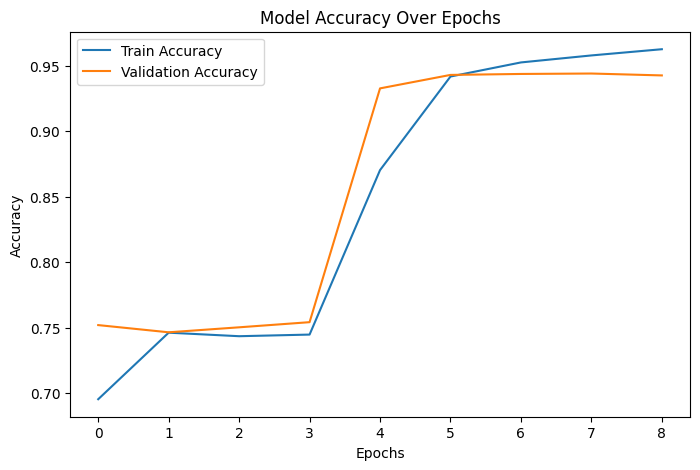

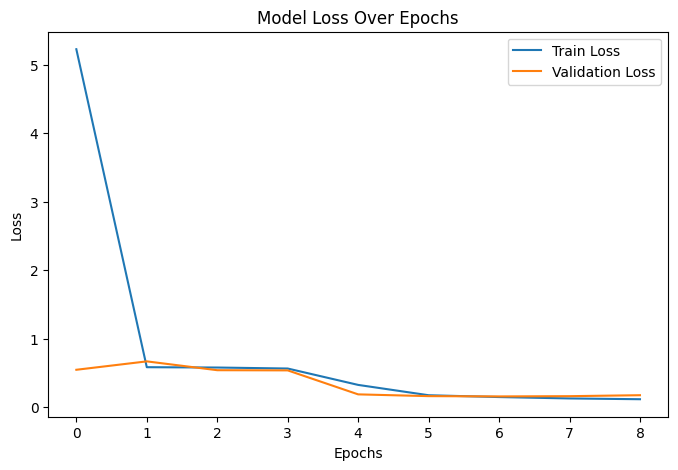

In [ ]:
print("Evaluating the fine-tuned GRU model...")
y_pred_fine_tuned = model.predict([X_test_text, X_test_additional])
y_pred_classes_fine_tuned = np.argmax(y_pred_fine_tuned, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print(f"Accuracy (Fine-Tuned Model): {accuracy_score(y_test_classes, y_pred_classes_fine_tuned):.2f}")
print("Classification Report (Fine-Tuned Model):")
print(classification_report(y_test_classes, y_pred_classes_fine_tuned))

# Plot training history
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
original_model = load_model(model_path)

# Evaluate model accuracy before adding personality features (with sentiment only)
print("Evaluating GRU model with sentiment analysis (before personality features)...")
y_pred_sentiment_only = original_model.predict(X_test_text_seq)
y_pred_classes_sentiment_only = np.argmax(y_pred_sentiment_only, axis=1)

accuracy_sentiment_only = accuracy_score(y_test_classes, y_pred_classes_sentiment_only)
print(f"Accuracy (With Sentiment Only): {accuracy_sentiment_only:.2f}")
print("Classification Report (With Sentiment Only):")
print(classification_report(y_test_classes, y_pred_classes_sentiment_only))

# Evaluate the fine-tuned GRU model (sentiment + personality)
print("\nEvaluating GRU model with sentiment and personality features...")
y_pred_personality = model.predict([X_test_text, X_test_additional])
y_pred_classes_personality = np.argmax(y_pred_personality, axis=1)

accuracy_personality = accuracy_score(y_test_classes, y_pred_classes_personality)
print(f"Accuracy (With Sentiment and Personality): {accuracy_personality:.2f}")
print("Classification Report (With Sentiment and Personality):")
print(classification_report(y_test_classes, y_pred_classes_personality))


Evaluating GRU model with sentiment analysis (before personality features)...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step
Accuracy (With Sentiment Only): 0.65
Classification Report (With Sentiment Only):
              precision    recall  f1-score   support

           0       0.69      0.54      0.61     34824
           1       0.62      0.76      0.68     34799

    accuracy                           0.65     69623
   macro avg       0.66      0.65      0.65     69623
weighted avg       0.66      0.65      0.65     69623


Evaluating GRU model with sentiment and personality features...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Accuracy (With Sentiment and Personality): 0.93
Classification Report (With Sentiment and Personality):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     34824
           1       0.93      0.94      0.94     34799

    accuracy                           0.93     69623
   macro avg       0.94      0.93     

In [ ]:
# Optional: Save the Fine-Tuned Model
fine_tuned_model_path = '/content/drive/My Drive/suicide_detection_GRU_with_personality.keras'
model.save(fine_tuned_model_path)
print(f"Fine-tuned GRU model saved at: {fine_tuned_model_path}")


<ipython-input-2-0e0ffd1ac073>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  polarity_class_counts = df.groupby(['polarity_range', 'class']).size().unstack()


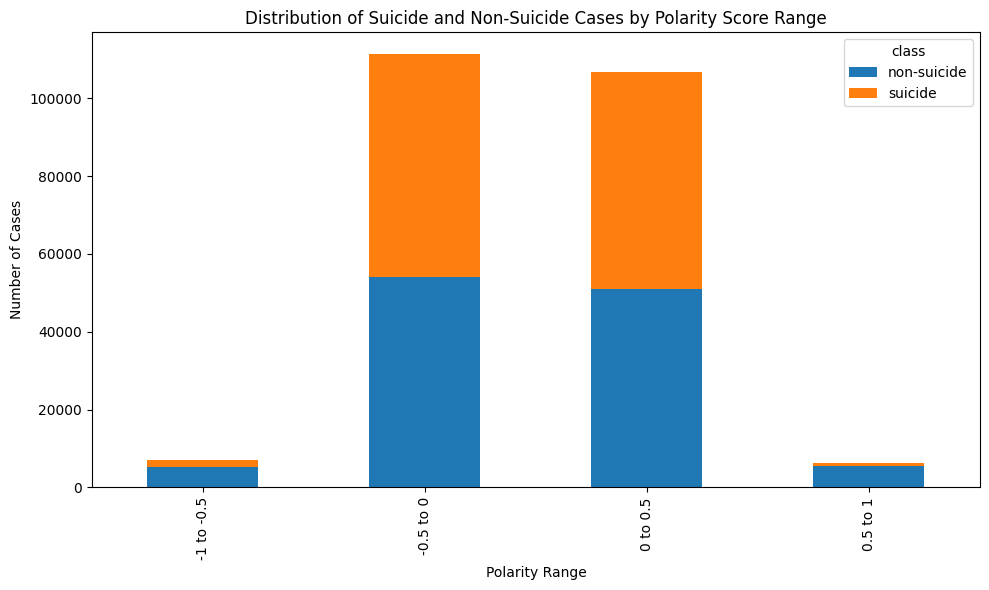

In [ ]:

import matplotlib.pyplot as plt

# Create bins for the polarity score ranges
bins = [-1, -0.5, 0, 0.5, 1]
labels = ['-1 to -0.5', '-0.5 to 0', '0 to 0.5', '0.5 to 1']

# Add a column with the bin labels based on the polarity score
df['polarity_range'] = pd.cut(df['polarity_score'], bins=bins, labels=labels)

# Group by polarity range and class (suicide or non-suicide), then count the number of cases
polarity_class_counts = df.groupby(['polarity_range', 'class']).size().unstack()

# Plot the data as a stacked bar chart
polarity_class_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Polarity Range')
plt.ylabel('Number of Cases')
plt.title('Distribution of Suicide and Non-Suicide Cases by Polarity Score Range')

# Show the plot
plt.tight_layout()
plt.show()


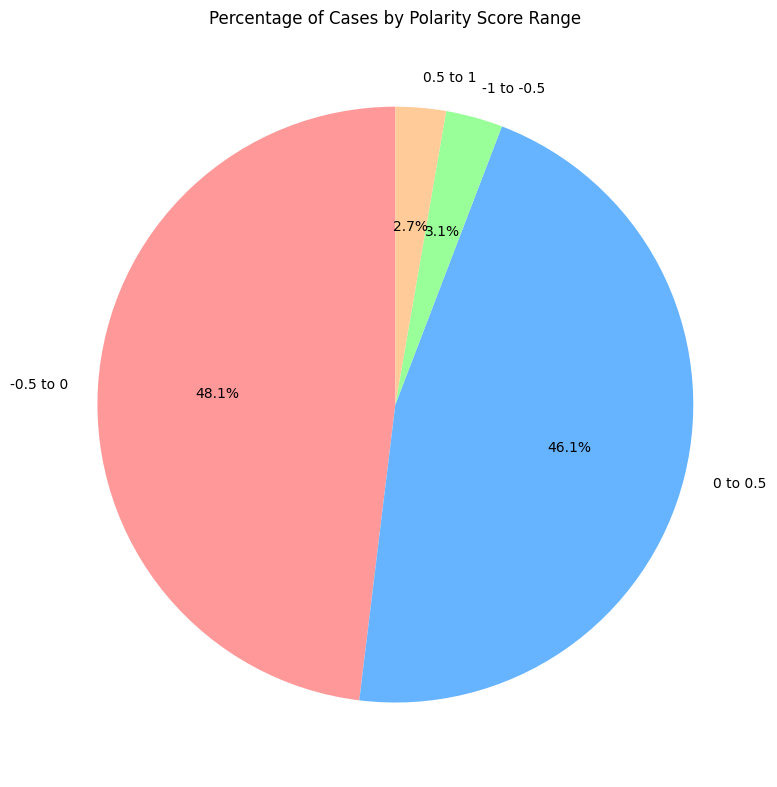

In [ ]:
# Calculate the total count for each polarity range
polarity_range_counts = df['polarity_range'].value_counts(normalize=True) * 100

# Plot a pie chart for the polarity ranges
plt.figure(figsize=(8, 8))
plt.pie(polarity_range_counts, labels=polarity_range_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Percentage of Cases by Polarity Score Range')

# Show the plot
plt.tight_layout()
plt.show()


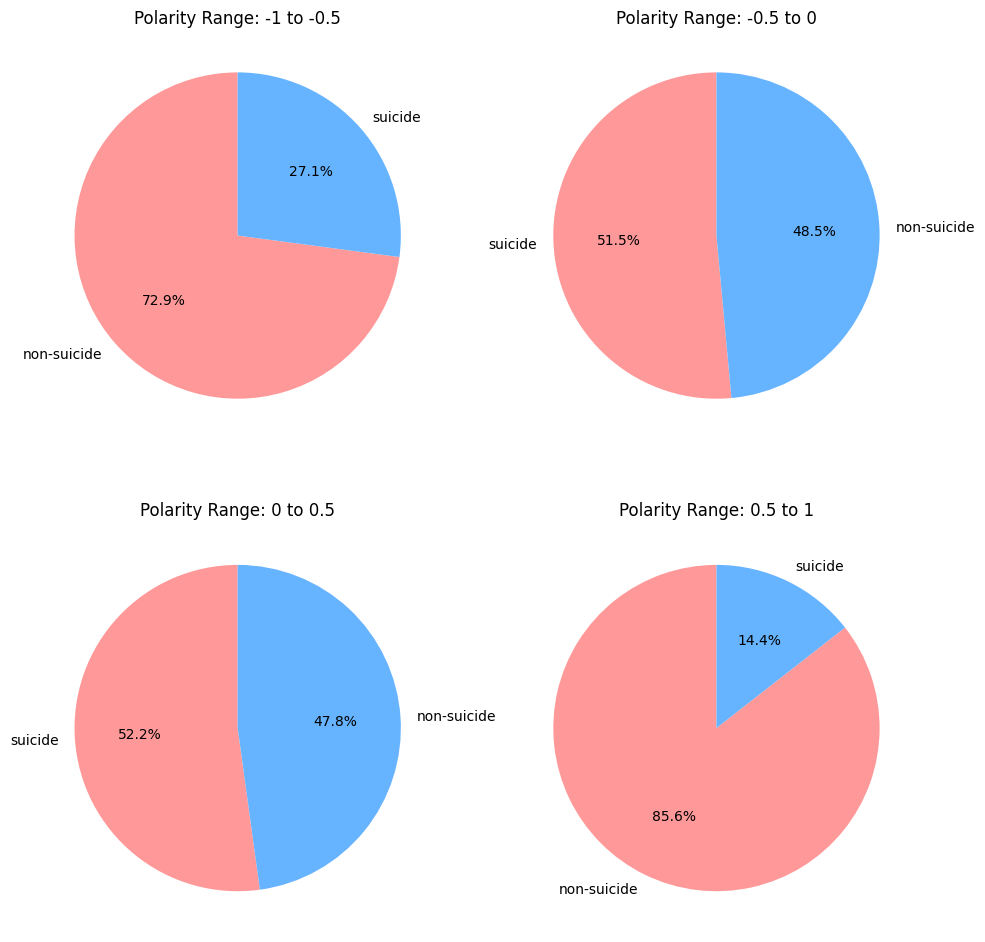

In [ ]:
# Create a figure for the pie charts
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop over each polarity range and create a pie chart
for i, label in enumerate(labels):
    # Filter data for the current polarity range
    data = df[df['polarity_range'] == label]['class'].value_counts()

    # Plot the pie chart
    axs[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
    axs[i].set_title(f'Polarity Range: {label}')

# Adjust layout
plt.tight_layout()
plt.show()
